## Look at the noisy hits from the SiPMs, what are they? where do they come from? should we care?

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
import os
import re
import sys
from tqdm import tqdm

sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io        import df_writer
from invisible_cities.io.dst_io        import load_dst

from invisible_cities.cities.beersheba import cut_over_Q
from invisible_cities.cities.beersheba import drop_isolated 
from invisible_cities.io.pmaps_io import load_pmaps
from invisible_cities.io.pmaps_io import load_pmaps_as_df
from invisible_cities.database.load_db import DataPMT, DataSiPM


In [6]:
def raw_plotter(q, evt, pitch = 15.55):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle("rebinned in Z")
    plt.show(fig)



In [46]:
low_thr_files = glob('low_thr_10022026/*000[0-9]*')
low_thr_files  = sorted(low_thr_files, key=lambda f: int(re.search(r'_000(\d)_', f).group(1)))

lsc_run_files = glob('lsc_run/*000[0-9]*')
lsc_run_files = sorted(lsc_run_files, key=lambda f: int(re.search(r'_000(\d)_', f).group(1)))

#print(low_thr_files)
#print(lsc_run_files)
low_thr_files_pmap = glob('low_thr_10022026_pmap/*000[0-9]*')
low_thr_files_pmap  = sorted(low_thr_files_pmap, key=lambda f: int(re.search(r'_000(\d)_', f).group(1)))

In [16]:
# define cut_over_Q and drop_isolated object
q_thr     = 7
drop_dist = [15.55, 15.55]

cut_sensors   = cut_over_Q(q_thr, ['E', 'Ec'])
drop_sensors  = drop_isolated(drop_dist, ['E', 'Ec'])

# list of evts
evts = [177, 219, 737, 842, 849, 954, 1045, 1087, 1094]

# generate folders to store data
for evt in evts:
    Path(f'evt{evt}_images').mkdir(parents=True, exist_ok=True)

lsc_EOI = []
thr_EOI = []
for lsc_file, thr_file in tqdm(zip(lsc_run_files, low_thr_files)):

    df_lsc = load_dst(lsc_file, 'RECO', 'Events')
    df_thr = load_dst(thr_file, 'RECO', 'Events')
    # extract the events of interest from the df
    df_lsc = df_lsc[df_lsc.event.isin(evts)]
    df_thr = df_thr[df_thr.event.isin(evts)]
    # cut and drop
    #df_lsc  = cut_sensors(df_lsc)
    #df_thr  = cut_sensors(df_thr)
    
    #df_lsc  = drop_sensors(df_lsc)
    #df_thr  = drop_sensors(df_thr)

    lsc_EOI.append(df_lsc)
    thr_EOI.append(df_thr)
    
    
 

10it [01:59, 11.94s/it]


In [17]:
# concat
lsc_EOI = pd.concat(lsc_EOI)
thr_EOI = pd.concat(thr_EOI)   

In [23]:
display(lsc_EOI)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
12999,177,1.746555e+09,0,114.823133,10.641630,1,-312.575,-402.675,0.0,0.0,832.035625,8.333459,46.687890,-1.0,NaN,-1,-1.0
13000,177,1.746555e+09,0,114.823133,10.641630,1,104.275,-356.525,0.0,0.0,832.035625,10.218158,57.246844,-1.0,0.000315,-1,-1.0
13001,177,1.746555e+09,0,114.823133,10.641630,1,10.975,60.325,0.0,0.0,835.662875,7.198497,152.164455,-1.0,0.000783,-1,-1.0
13002,177,1.746555e+09,0,114.823133,10.641630,1,351.075,-109.225,0.0,0.0,835.662875,7.084815,149.761397,-1.0,0.000816,-1,-1.0
13003,177,1.746555e+09,0,114.823133,10.641630,1,366.625,-109.225,0.0,0.0,835.662875,13.651507,288.570549,-1.0,0.001601,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,1094,1.746555e+09,1,-61.463783,-195.273854,1,-81.325,-294.325,0.0,0.0,847.014625,13.001585,123.571004,-1.0,0.000666,-1,-1.0
21593,1094,1.746555e+09,1,-61.463783,-195.273854,1,-65.775,-325.425,0.0,0.0,847.014625,8.919671,84.775257,-1.0,0.000460,-1,-1.0
21594,1094,1.746555e+09,1,-61.463783,-195.273854,1,-65.775,-294.325,0.0,0.0,847.014625,7.653030,72.736720,-1.0,0.000390,-1,-1.0
21595,1094,1.746555e+09,1,-61.463783,-195.273854,1,-359.225,-418.225,0.0,0.0,850.214250,11.226818,89.319533,-1.0,NaN,-1,-1.0


In [24]:
# kill the screamer
print(lsc_EOI.shape[0])
lsc_EOI = lsc_EOI[~((lsc_EOI.X == 243.225) & (lsc_EOI.Y == -340.975))]
print(lsc_EOI.shape[0])

print(thr_EOI.shape[0])
thr_EOI = thr_EOI[~((thr_EOI.X == 243.225) & (thr_EOI.Y == -340.975))]
print(thr_EOI.shape[0])


16814
16814
2472960
2472270


In [19]:
q_thr = 7
cut_sensors = cut_over_Q(q_thr, ['E', 'Ec'])

In [20]:
# list the events
print(lsc_EOI.event.unique())

[ 177  219  737  842  849  954 1045 1087 1094]


### apply a q_cut of 7 to the thr_EOI data

LSC event


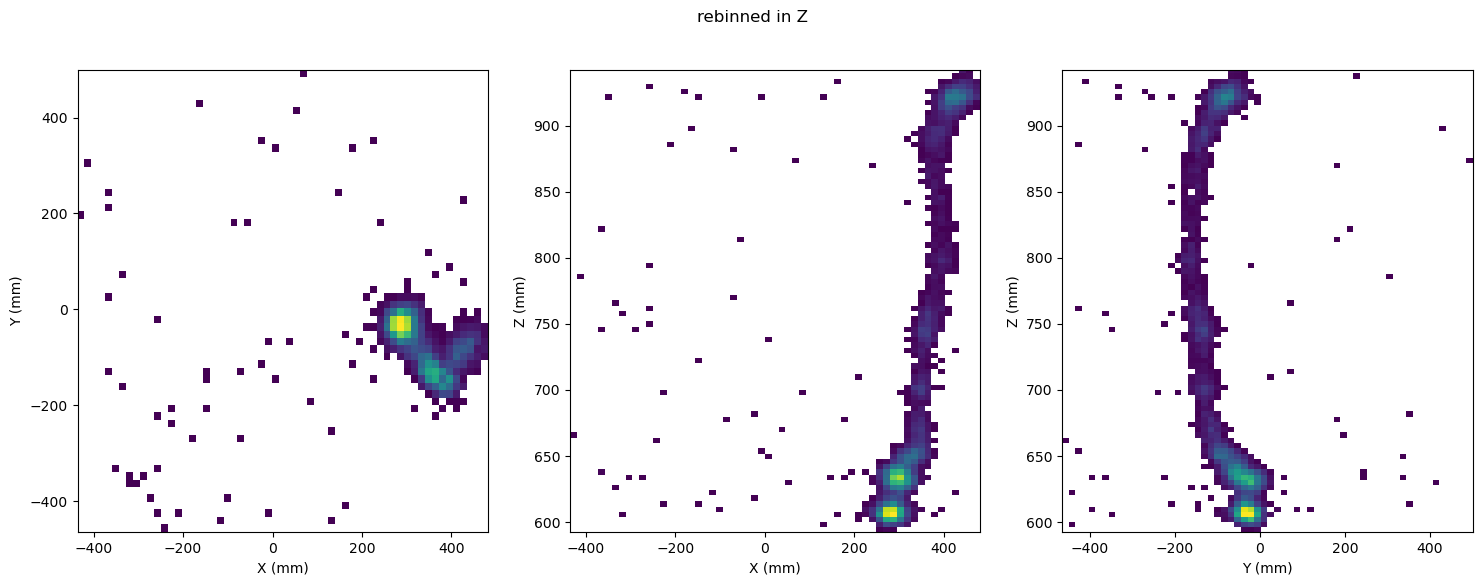

No thresholds


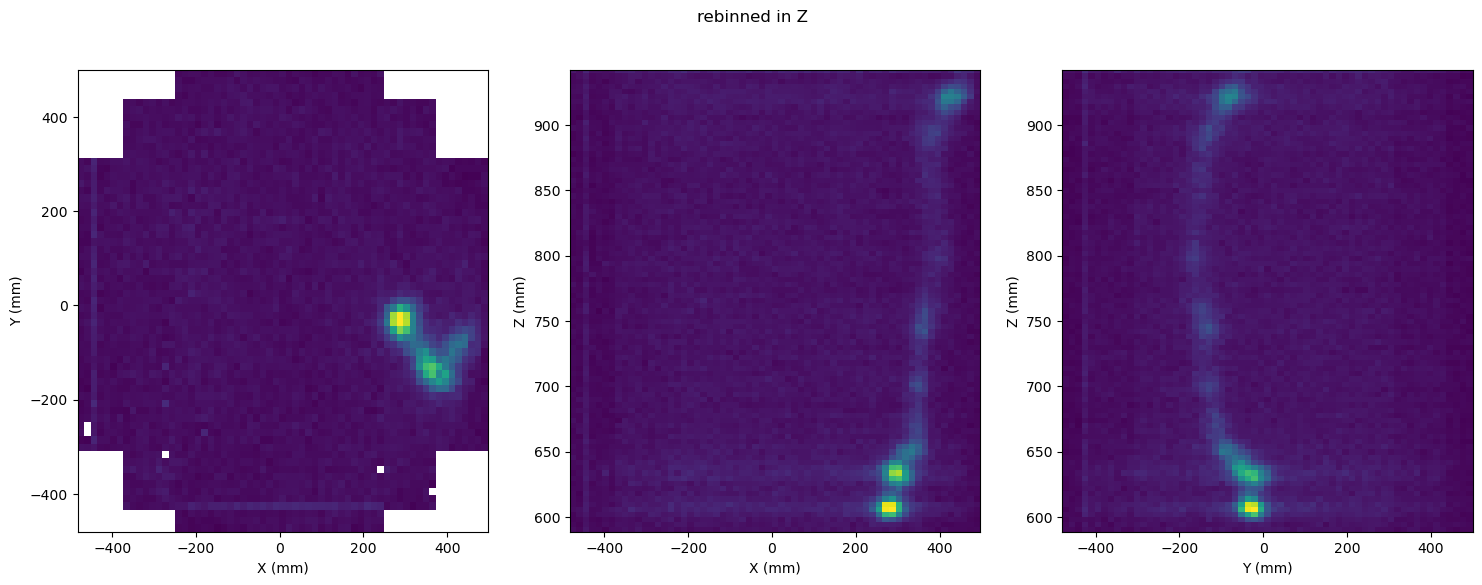

No thresholds with cut at 7


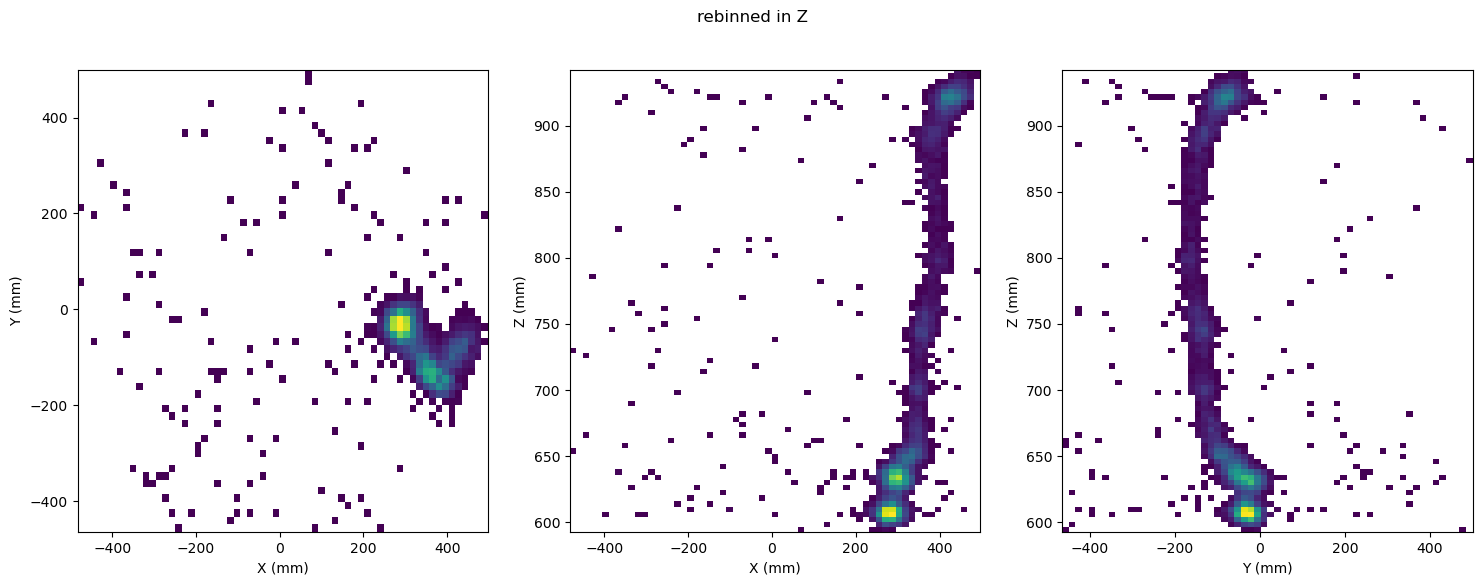

In [25]:
evt = 842
lsc_EOI_evt = lsc_EOI[lsc_EOI.event == evt]
thr_EOI_evt = thr_EOI[thr_EOI.event == evt]

print('LSC event')
raw_plotter(lsc_EOI_evt, evt)
print('No thresholds')
raw_plotter(thr_EOI_evt, evt)
print(f'No thresholds with cut at {q_thr}')
raw_plotter(cut_sensors(thr_EOI_evt), evt)

1601


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3234,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,592.452250,7.585540,400.646677,-1.0,0.002107,-1,-1.0
3242,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,596.089500,21.019474,280.586388,-1.0,0.001476,-1,-1.0
3273,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,599.933375,33.816452,388.327628,-1.0,0.002043,-1,-1.0
3317,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,603.721500,54.720119,510.249543,-1.0,0.002685,-1,-1.0
3371,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,607.535875,41.691517,310.583702,-1.0,0.001634,-1,-1.0
3411,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,611.502000,17.892611,138.263407,-1.0,0.000728,-1,-1.0
3441,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,615.706875,7.180206,64.550112,-1.0,0.000340,-1,-1.0
3464,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,619.900125,9.612211,113.685895,-1.0,0.000599,-1,-1.0
3497,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,623.924750,10.596594,125.628594,-1.0,0.000662,-1,-1.0
3601,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,631.674750,13.318124,122.145173,-1.0,0.000643,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
1508291,842,1.746555e+09,0,62.969437,-5.69754,1,257.775,-1.375,0.0,0.0,588.630625,0.353388,0.026815,-1.0,-1.0,-1,-1.0
1511875,842,1.746555e+09,0,62.969437,-5.69754,1,257.775,-1.375,0.0,0.0,592.453000,8.599111,6.238303,-1.0,-1.0,-1,-1.0
1515459,842,1.746555e+09,0,62.969437,-5.69754,1,257.775,-1.375,0.0,0.0,596.089375,21.379980,45.648482,-1.0,-1.0,-1,-1.0
1519043,842,1.746555e+09,0,62.969437,-5.69754,1,257.775,-1.375,0.0,0.0,599.932875,34.396442,113.061610,-1.0,-1.0,-1,-1.0
1522627,842,1.746555e+09,0,62.969437,-5.69754,1,257.775,-1.375,0.0,0.0,603.720250,55.658627,182.166399,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1812931,842,1.746555e+09,0,62.969437,-5.69754,1,257.775,-1.375,0.0,0.0,927.468000,0.176694,0.206595,-1.0,-1.0,-1,-1.0
1816515,842,1.746555e+09,0,62.969437,-5.69754,1,257.775,-1.375,0.0,0.0,931.378375,2.414819,1.460650,-1.0,-1.0,-1,-1.0
1820099,842,1.746555e+09,0,62.969437,-5.69754,1,257.775,-1.375,0.0,0.0,935.493250,0.000000,0.000000,-1.0,-1.0,-1,-1.0
1823683,842,1.746555e+09,0,62.969437,-5.69754,1,257.775,-1.375,0.0,0.0,939.540625,0.706776,0.150965,-1.0,-1.0,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3634,842,1.746555e+09,0,122.218873,-24.048902,1,-359.225,29.725,0.0,0.0,635.580875,7.174044,59.482838,-1.0,0.000323,-1,-1.0


7.174043655395508


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
1505797,842,1.746555e+09,0,62.969437,-5.69754,1,-359.225,29.725,0.0,0.0,588.630625,4.952919,0.375821,-1.0,-1.0,-1,-1.0
1509381,842,1.746555e+09,0,62.969437,-5.69754,1,-359.225,29.725,0.0,0.0,592.453000,0.291348,0.211361,-1.0,-1.0,-1,-1.0
1512965,842,1.746555e+09,0,62.969437,-5.69754,1,-359.225,29.725,0.0,0.0,596.089375,0.291348,0.622059,-1.0,-1.0,-1,-1.0
1516549,842,1.746555e+09,0,62.969437,-5.69754,1,-359.225,29.725,0.0,0.0,599.932875,0.174809,0.574599,-1.0,-1.0,-1,-1.0
1520133,842,1.746555e+09,0,62.969437,-5.69754,1,-359.225,29.725,0.0,0.0,603.720250,0.233078,0.762848,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810437,842,1.746555e+09,0,62.969437,-5.69754,1,-359.225,29.725,0.0,0.0,927.468000,1.573280,1.839514,-1.0,-1.0,-1,-1.0
1814021,842,1.746555e+09,0,62.969437,-5.69754,1,-359.225,29.725,0.0,0.0,931.378375,0.349618,0.211473,-1.0,-1.0,-1,-1.0
1817605,842,1.746555e+09,0,62.969437,-5.69754,1,-359.225,29.725,0.0,0.0,935.493250,0.524427,0.145699,-1.0,-1.0,-1,-1.0
1821189,842,1.746555e+09,0,62.969437,-5.69754,1,-359.225,29.725,0.0,0.0,939.540625,0.349618,0.074677,-1.0,-1.0,-1,-1.0


73.76934599876404


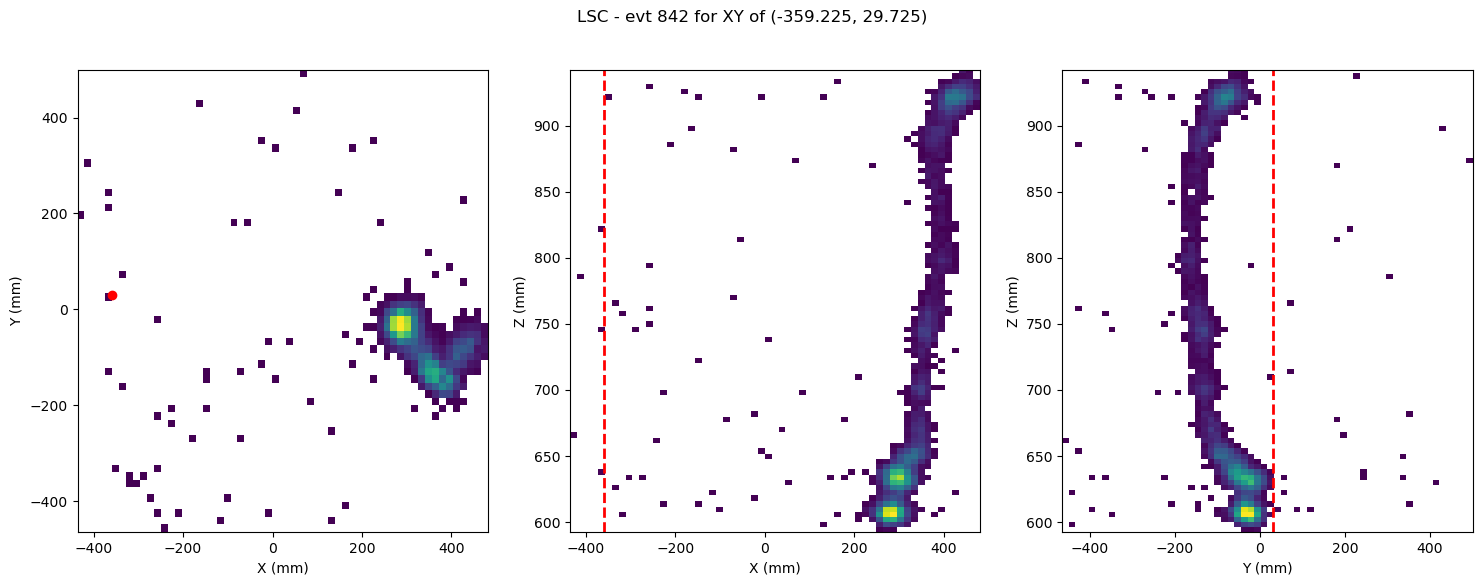

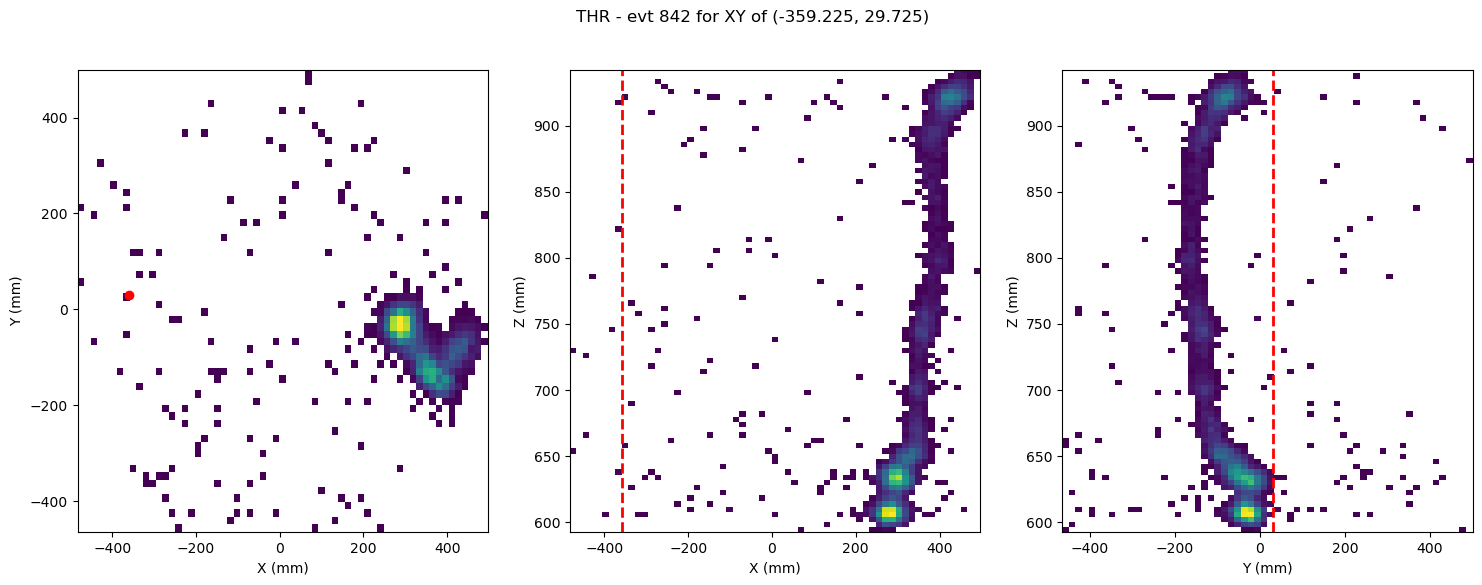

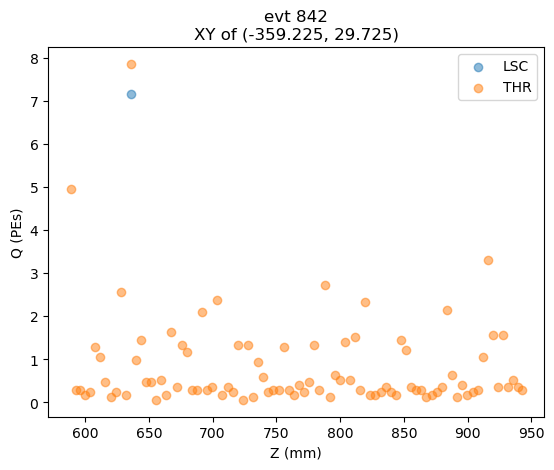

In [200]:
thr_list = list(zip(lsc_EOI_evt.X.values, lsc_EOI_evt.Y.values))
lsc_list = list(zip(thr_EOI_evt.X.values, thr_EOI_evt.Y.values))
#print(thr_list)
#print(lsc_list)
matches = [t for t in thr_list if t in lsc_list]
print(len(matches))


x_val = matches[0][0]
y_val = matches[0][1]

df_lsc_xy = lsc_EOI_evt[(lsc_EOI_evt.X == x_val) & (lsc_EOI_evt.Y == y_val)]
display(df_lsc_xy)

df_thr_xy = thr_EOI_evt[(thr_EOI_evt.X == x_val) & (thr_EOI_evt.Y == y_val)]
display(df_thr_xy)

xy_index = 400

x_val = matches[xy_index][0]
y_val = matches[xy_index][1]

df_lsc_xy = lsc_EOI_evt[(lsc_EOI_evt.X == x_val) & (lsc_EOI_evt.Y == y_val)]
display(df_lsc_xy)
print(df_lsc_xy.Q.sum())

df_thr_xy = thr_EOI_evt[(thr_EOI_evt.X == x_val) & (thr_EOI_evt.Y == y_val)]
display(df_thr_xy)
print(df_thr_xy.Q.sum())


q = lsc_EOI_evt
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.sort(q.Z.unique())

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[0].scatter(x_val, y_val, c = 'red')

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[1].axvline(x=x_val, color='red', linestyle='--', linewidth=2) 

axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
axes[2].axvline(x=y_val, color='red', linestyle='--', linewidth=2) 

fig.suptitle(f"LSC - evt {q.event.unique()[0]} for XY of {x_val, y_val}")
plt.show(fig)

q = cut_sensors(thr_EOI_evt)
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.sort(q.Z.unique())

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[0].scatter(x_val, y_val, c = 'red')

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[1].axvline(x=x_val, color='red', linestyle='--', linewidth=2) 

axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
axes[2].axvline(x=y_val, color='red', linestyle='--', linewidth=2) 

fig.suptitle(f"THR - evt {q.event.unique()[0]} for XY of {x_val, y_val}")
plt.show(fig)


plt.scatter(df_lsc_xy.Z.values, df_lsc_xy.Q.values, label = 'LSC', alpha = 0.5)
plt.scatter(df_thr_xy.Z.values, df_thr_xy.Q.values, label = 'THR', alpha = 0.5)
plt.xlabel('Z (mm)')
plt.ylabel('Q (PEs)')
plt.title(f'evt {df_lsc_xy.event.unique()[0]}\nXY of {x_val, y_val}')
#plt.xlim([590, 650])
plt.legend()
plt.show()




In [187]:
sipm_df = DataSiPM('next100', 15281)
display(sipm_df)

OperationalError: unable to open database file

In [188]:
lsc_EOI_pmap = []
thr_EOI_pmap = []
for thr_file in low_thr_files_pmap:
    #df_thr_pmap_df = load_pmaps_as_df(thr_file)
    df_thr_pmap =    load_pmaps(thr_file)
    
    # cut and drop
    #df_lsc  = cut_sensors(df_lsc)
    #df_thr  = cut_sensors(df_thr)
    
    #df_lsc  = drop_sensors(df_lsc)
    #df_thr  = drop_sensors(df_thr)

    if 842 in df_thr_pmap:
        break

In [189]:
display(df_thr_pmap[842])
#print(df_thr_pmap[842].s2s[0].pmts)
print(df_thr_pmap[842].s2s[0].sipms.waveform(sensor_id = 517))


---------------------
PMap instance
---------------------
Number of S1s: 156
Number of S2s: 1

[0.05826962 0.87404436 3.2048295  0.81577474 0.17480887 0.
 0.05826962 0.05826962 0.         0.         0.11653925 0.17480887
 0.         0.05826962 0.05826962 0.05826962 0.05826962 0.05826962
 0.         0.11653925 0.         0.466157   0.6409659  0.17480887
 0.         0.05826962 0.466157   0.52442664 0.2330785  0.05826962
 0.         0.17480887 0.         0.         0.11653925 0.
 0.         0.17480887 0.         0.05826962 1.0488533  0.7575051
 0.40788737 0.34961775 0.         0.         0.17480887 0.
 5.1859965  2.2725153  0.40788737 0.         0.17480887 0.
 0.05826962 0.7575051  0.29134813 0.17480887 0.81577474 0.17480887
 0.29134813 0.05826962 0.         0.11653925 0.11653925 0.
 0.2330785  0.11653925 0.         0.05826962 0.         0.
 0.2330785  0.         0.05826962 0.2330785  0.         0.
 0.17480887 0.         0.2330785  0.11653925 0.99058366 0.29134813
 0.17480887 0.         0.17480887 0.         0.         0.87404436
 0.40788737 0.05826962 0.11653925 0.         0.58269

In [190]:
print(thr_EOI_pmap[0].keys())

IndexError: list index out of range

In [191]:
sens_id = 517
pmap_evt = df_thr_pmap[evt].s2s[0]
wf = pmap_evt.sipms.waveform(sensor_id = sens_id)

In [237]:
# modify shape for rebinning
wf_mod = np.append(wf, [0])
print(len(wf))
print(wf_mod)
wf_mod = wf_mod.reshape(len(wf_mod)//4, 4)

times_mod = pmap_evt.times
print(len(times_mod))
times_mod = np.append(times_mod, times_mod[-1] + np.diff(times_mod)[0])
times_mod = times_mod.reshape(len(times_mod)//4, 4)

359
[0.05826962 0.87404436 3.20482945 0.81577474 0.17480887 0.
 0.05826962 0.05826962 0.         0.         0.11653925 0.17480887
 0.         0.05826962 0.05826962 0.05826962 0.05826962 0.05826962
 0.         0.11653925 0.         0.46615699 0.64096588 0.17480887
 0.         0.05826962 0.46615699 0.52442664 0.23307849 0.05826962
 0.         0.17480887 0.         0.         0.11653925 0.
 0.         0.17480887 0.         0.05826962 1.04885328 0.75750512
 0.40788737 0.34961775 0.         0.         0.17480887 0.
 5.18599653 2.2725153  0.40788737 0.         0.17480887 0.
 0.05826962 0.75750512 0.29134813 0.17480887 0.81577474 0.17480887
 0.29134813 0.05826962 0.         0.11653925 0.11653925 0.
 0.23307849 0.11653925 0.         0.05826962 0.         0.
 0.23307849 0.         0.05826962 0.23307849 0.         0.
 0.17480887 0.         0.23307849 0.11653925 0.99058366 0.29134813
 0.17480887 0.         0.17480887 0.         0.         0.87404436
 0.40788737 0.05826962 0.11653925 0.         0.

In [193]:
print(times_mod)
#meaner = np.mean(times_mod, axis = 1)
print(meaner)

[[1387504.5 1388559.6 1389572.8 1390527.  1391556.9 1392537.6 1393534.5
  1394522.5 1395512.5 1396523.1 1397502.8 1398508.6 1399496.2 1400501.2
  1401501.9 1402499.8 1403483.1 1404486.2 1405484.4 1406489.  1407479.9
  1408475.8 1409472.8 1410472.8 1411474.9 1412471.6 1413473.9 1414482.9
  1415494.5 1416483.5 1417480.5 1418509.  1419501.5 1420496.8 1421511.2
  1422501.5 1423513.2 1424491.  1425499.1 1426486.4 1427490.5 1428489.5
  1429494.2 1430488.5 1431491.  1432482.8 1433488.2 1434484.1 1435476.9
  1436485.4 1437480.2 1438474.6 1439485.8 1440474.4 1441487.  1442491.2
  1443485.1 1444484.4 1445486.9 1446492.8 1447488.6 1448486.2 1449482.1
  1450478.2 1451484.4 1452488.1 1453458.  1454460.  1455472.9 1456507.6
  1457463.9 1458483.1 1459488.1 1460515.1 1461486.4 1462492.8 1463475.5
  1464475.9 1465479.8 1466489.1 1467486.8 1468481.4 1469476.6 1470470.5
  1471480.5 1472483.5 1473481.8 1474472.2 1475485.5 1476497.5]
 [1477456.  1478480.8 1479465.8 1480486.2 1481467.1 1482467.4 1483451.1
 

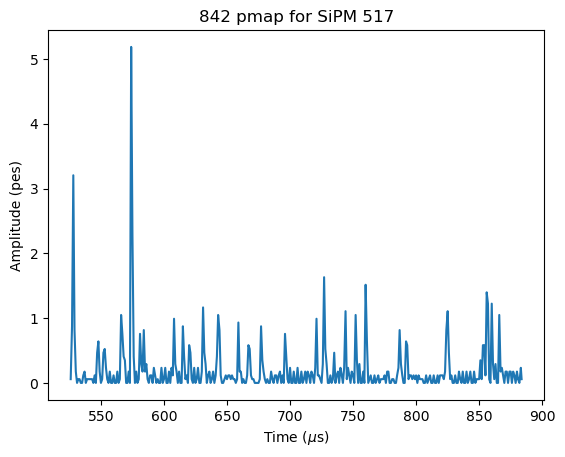

In [221]:
plt.plot((pmap_evt.times / 1e3) + 588.63 - 2900/2, wf)

plt.title(f'{evt} pmap for SiPM {sens_id}')
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Amplitude (pes)')
plt.show()

628.2102


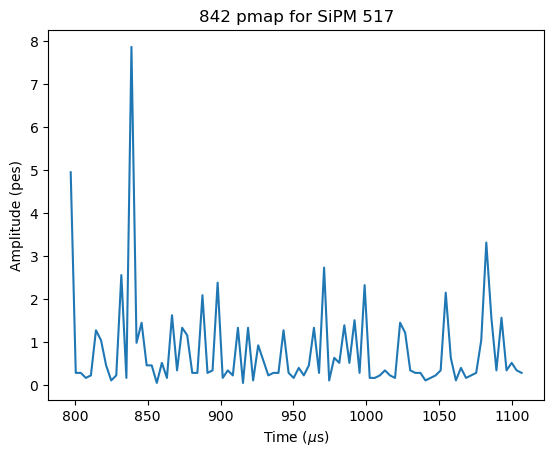

In [240]:
plt.plot((0.87 * ((np.mean(times_mod, axis = 1)) / 1e3) + 788.63 - 2000/2), np.sum(wf_mod, axis = 1))
print(np.max(0.87 * ((np.mean(times_mod, axis = 0)) / 1e3) + 588.63 - 2650/2))
plt.title(f'{evt} pmap for SiPM {sens_id}')
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Amplitude (pes)')
plt.show()

In [195]:
np.sum(wf)

73.76935

73.76934599876404
588.630625


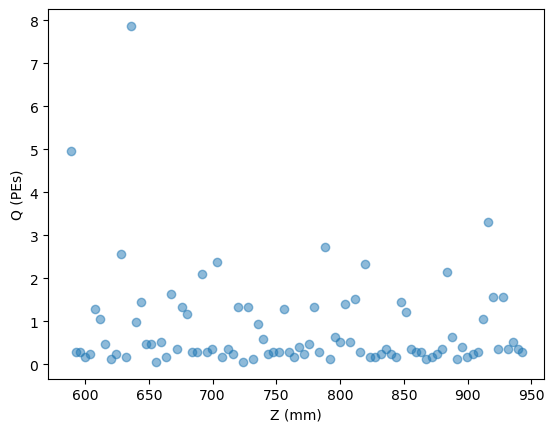

In [223]:
plt.scatter(df_thr_xy.Z.values, df_thr_xy.Q.values, label = 'THR', alpha = 0.5)
print(np.sum(df_thr_xy.Q.values))
print(df_thr_xy.Z.min())
#plt.xlim([588.630625, 665.5641])
plt.xlabel('Z (mm)')
plt.ylabel('Q (PEs)')
plt.show()

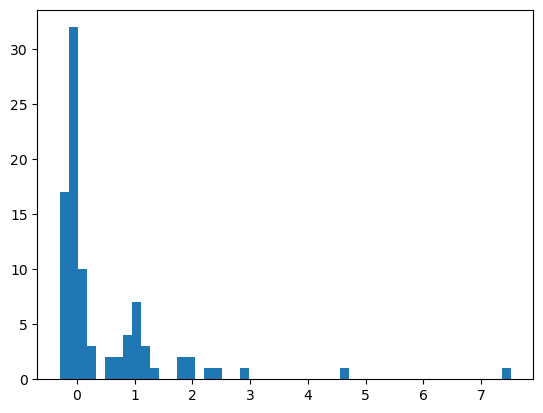

90


In [256]:
plt.hist(df_thr_xy.Q.values - np.median(df_thr_xy.Q.values), bins = 50)
plt.show()

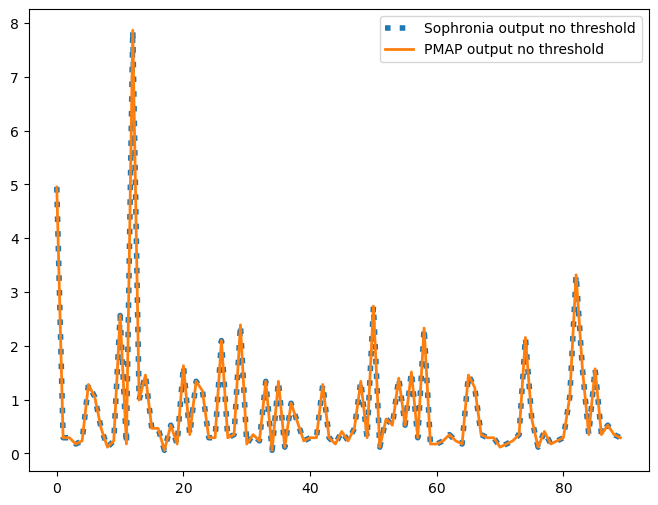

In [250]:
plt.figure(figsize=(8,6))
plt.plot(df_thr_xy.Q.values, linewidth = 4, linestyle = ':', label = 'Sophronia output no threshold')
plt.plot(np.sum(wf_mod, axis = 1), linewidth = 2, label = 'PMAP output no threshold')

plt.legend()

In [155]:
# list of evts
evts = [842]

# generate folders to store data
for evt in evts:
    Path(f'evt{evt}_images').mkdir(parents=True, exist_ok=True)

lsc_EOI = []
thr_EOI = []
for lsc_file, thr_file in tqdm(zip(lsc_run_files, low_thr_files)):

    df_thr = load_dst(thr_file, 'DST', 'Events')
    # extract the events of interest from the df
    df_lsc = df_lsc[df_lsc.event.isin(evts)]
    df_thr = df_thr[df_thr.event.isin(evts)]
    # cut and drop
    #df_lsc  = cut_sensors(df_lsc)
    #df_thr  = cut_sensors(df_thr)
    
    #df_lsc  = drop_sensors(df_lsc)
    #df_thr  = drop_sensors(df_thr)

    lsc_EOI.append(df_lsc)
    thr_EOI.append(df_thr)
    

10it [00:00, 19.56it/s]


In [163]:
display(thr_EOI[1].S1t)

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
22,842,1.746555e+09,0,0,1,1,325.0,65.810257,362.72876,801250.0,...,3580,602.233154,602.233154,115.801328,62.969437,-5.69754,63.226671,-0.090235,268.760622,237.690974


In [236]:
x = np.array(list(range(12)))
print(x)
x = x.reshape(4, len(x)//4)
print(x)
x = np.sum(x, axis = 1)
print(x)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
[ 3 12 21 30]
